In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

In [2]:
def ReadFile(file_path):

    # Open and read the file, skipping lines until we reach the data section
    with open(file_path, "r") as file:
        lines = file.readlines()

    # Find where the data starts
    for i, line in enumerate(lines):
        if line.strip() == "Analog Scan Data":
            data_start = i + 3 # Skip the header and seperator
            break
            
    # Load only the numerical data into a DataFrame
    df = pd.read_csv(file_path, skiprows=data_start, delimiter=",")

    # Display the first few rows
    print(df.head())

    return df

DataWarm        = ReadFile("WARM2.txt")
DataCold        = ReadFile("COLD13.txt")
Background      = ReadFile("BG.txt")


DataWarm   = DataWarm.rename(columns={"              Mass (AMU)": "Mass", "         Intensity (Torr)": "Intensity"})
DataCold   = DataCold.rename(columns={"              Mass (AMU)": "Mass", "         Intensity (Torr)": "Intensity"})
Background = Background.rename(columns={"              Mass (AMU)": "Mass", "         Intensity (Torr)": "Intensity"})


print(Background.columns)

        Mass (AMU)  Intensity (Torr)
0             1.00      6.485800e-11
1             1.04      7.250000e-11
2             1.08      8.934400e-11
3             1.12      1.205900e-10
4             1.16      1.787900e-10
        Mass (AMU)  Intensity (Torr)
0             1.00      4.792600e-11
1             1.04      5.531900e-11
2             1.08      6.815600e-11
3             1.12      8.352800e-11
4             1.16      1.120400e-10
        Mass (AMU)  Intensity (Torr)
0             1.00      2.296100e-11
1             1.04      2.663100e-11
2             1.08      4.581600e-11
3             1.12      1.124500e-10
4             1.16      7.412600e-10
Index(['Mass', 'Intensity'], dtype='object')


In [3]:
# Runs were taken at different absolute pressures in the RGA therefore we need the partial pressure

def normalize_area(df):
    #Trapezodial integration along the curve
    area = np.trapz(df["Intensity"], df["Mass"])
    if area == 0:
        return df
    df_norm = df.copy()
    #Normalize the new data to 1
    df_norm["Intensity"] = df["Intensity"] / area
    return df_norm

DataWarm_norm   = normalize_area(DataWarm)
DataCold_norm   = normalize_area(DataCold)
Background_norm = normalize_area(Background)

In [4]:
# There is some background gas in the RGA and system, therefore we want to subtract that

def subtract_background(df, bg):
    #The data is not necessaryly along the same axis therefore I want to get them onto the same axis
    bg_interp = np.interp(df["Mass"], bg["Mass"], bg["Intensity"])
    df_corr = df.copy()
    #Subtract the background from the data frame
    df_corr["Intensity"] = df_corr["Intensity"] - bg_interp
    return df_corr

DataWarm_BS  = subtract_background(DataWarm_norm, Background_norm)
DataCold_BS  = subtract_background(DataCold_norm, Background_norm)

In [5]:
WINDOWS = {
    "Ar_Single":  (36, 41.0),  
    "Ar_Double":  (19.0, 21.0),  
    "Xe_Double":  (63.0, 70.0),
    "Xe_Single":  (126.0, 137.0),
}

def ROI(df, lo, hi):
    """Integrate intensity over [lo, hi], clipping negatives to 0."""
    m = df["Mass"].values
    y = df["Intensity"].values
    mask = (m >= lo) & (m <= hi)
    if not np.any(mask):
        return 0.0
    return float(np.trapz(np.clip(y[mask], 0, None), m[mask]))

def compositions(df_bgsub, windows=WINDOWS):
    """Return absolute areas (parts) and % fractions (fracs) for each ROI."""
    parts = {name: ROI(df_bgsub, *w) for name, w in windows.items()}
    total_all = ROI(df_bgsub, df_bgsub["Mass"].min(), df_bgsub["Mass"].max())
    other = max(total_all - sum(parts.values()), 0.0)  # never negative
    parts["Other"] = other

    denom = sum(parts.values())
    if denom <= 0:
        fracs = {k: 0.0 for k in parts}
    else:
        fracs = {k: 100.0 * v / denom for k, v in parts.items()}
    return parts, fracs

# --- Optional: visualize ROIs on a spectrum ---
def highlight_windows(ax, windows=WINDOWS, alpha=0.15):
    """
    Shade ROI bands on an existing matplotlib Axes.
    Call after plotting m/z vs intensity.
    """
    for name, (lo, hi) in windows.items():
        ax.axvspan(lo, hi, alpha=alpha, label=name)
    # Avoid duplicate legend entries
    handles, labels = ax.get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    ax.legend(uniq.values(), uniq.keys(), frameon=False)

# Example usage:
# fig, ax = plt.subplots()
# ax.plot(df_bgsub["Mass"], df_bgsub["Intensity"])
# highlight_windows(ax, WINDOWS)
# plt.show()



In [6]:
PartsWarm, FracWarm = compositions(DataWarm_BS, WINDOWS)
PartsCold, FracCold = compositions(DataCold_BS, WINDOWS)

# Warm data
XeWarm = PartsWarm["Xe_Single"] + PartsWarm["Xe_Double"]
ArWarm = PartsWarm["Ar_Single"] + PartsWarm["Ar_Double"]
TotWarm = XeWarm + ArWarm + PartsWarm["Other"]

print("Warm:")
print("  Xe_Single:", PartsWarm["Xe_Single"])
print("  Xe_Double:", PartsWarm["Xe_Double"])
print("  Ar_Single:", PartsWarm["Ar_Single"])
print("  Ar_Double:", PartsWarm["Ar_Double"])
print("  Other:", PartsWarm["Other"])
print("  Total Warm:", TotWarm)

# Cold data
XeCold = PartsCold["Xe_Single"] + PartsCold["Xe_Double"]
ArCold = PartsCold["Ar_Single"] + PartsCold["Ar_Double"]
TotCold = XeCold + ArCold + PartsCold["Other"]

print("\nCold:")
print("  Xe_Single:", PartsCold["Xe_Single"])
print("  Xe_Double:", PartsCold["Xe_Double"])
print("  Ar_Single:", PartsCold["Ar_Single"])
print("  Ar_Double:", PartsCold["Ar_Double"])
print("  Other:", PartsCold["Other"])
print("  Total Cold:", TotCold)

Warm:
  Xe_Single: 0.0068406850685199284
  Xe_Double: 0.029999708640382573
  Ar_Single: 0.572974889856973
  Ar_Double: 0.06359162360734077
  Other: 0.0017890360509705827
  Total Warm: 0.6751959432241867

Cold:
  Xe_Single: 0.00010645024088908492
  Xe_Double: 0.0006785256293121609
  Ar_Single: 0.6337072225453345
  Ar_Double: 0.11041455402393631
  Other: 0.002373200279683463
  Total Cold: 0.7472799527191555


In [7]:
# Sums for Ar
ArWarm = PartsWarm["Ar_Single"] + PartsWarm["Ar_Double"]
ArCold = PartsCold["Ar_Single"] + PartsCold["Ar_Double"]

# --- regular full fractions including Other ---
Frac_Xe_Warm  = 100 * XeWarm / TotWarm
Frac_Ar_Warm  = 100 * ArWarm / TotWarm
Frac_Oth_Warm = 100 * PartsWarm["Other"] / TotWarm

Frac_Xe_Cold  = 100 * XeCold / TotCold
Frac_Ar_Cold  = 100 * ArCold / TotCold
Frac_Oth_Cold = 100 * PartsCold["Other"] / TotCold

print("Before cooling (with Other):", Frac_Xe_Warm, Frac_Ar_Warm, Frac_Oth_Warm)
print("After  cooling (with Other):", Frac_Xe_Cold, Frac_Ar_Cold, Frac_Oth_Cold)

# --- Xe vs Ar only (ignore Other) ---
Frac_Xe_Warm_noOth = 100 * XeWarm / (XeWarm + ArWarm)
Frac_Ar_Warm_noOth = 100 - Frac_Xe_Warm_noOth

Frac_Xe_Cold_noOth = 100 * XeCold / (XeCold + ArCold)
Frac_Ar_Cold_noOth = 100 - Frac_Xe_Cold_noOth

print("\nBefore cooling (Xe vs Ar only): Xe =", Frac_Xe_Warm_noOth, "Ar =", Frac_Ar_Warm_noOth)
print("After  cooling (Xe vs Ar only):  Xe =", Frac_Xe_Cold_noOth, "Ar =", Frac_Ar_Cold_noOth)


Before cooling (with Other): 5.456252229979751 94.27878230793118 0.2649654620890643
After  cooling (with Other): 0.10504441706818507 99.57737710768329 0.3175784752485344

Before cooling (Xe vs Ar only): Xe = 5.470747822226642 Ar = 94.52925217777336
After  cooling (Xe vs Ar only):  Xe = 0.10537907833840313 Ar = 99.8946209216616


        Mass (AMU)  Intensity (Torr)
0             1.00      1.462400e-10
1             1.04      1.521600e-10
2             1.08      1.763100e-10
3             1.12      2.280500e-10
4             1.16      4.265400e-10
        Mass (AMU)  Intensity (Torr)
0             1.00      6.485800e-11
1             1.04      7.250000e-11
2             1.08      8.934400e-11
3             1.12      1.205900e-10
4             1.16      1.787900e-10
        Mass (AMU)  Intensity (Torr)
0             1.00      4.648900e-11
1             1.04      4.718100e-11
2             1.08      4.870600e-11
3             1.12      6.891800e-11
4             1.16      1.228500e-10
        Mass (AMU)  Intensity (Torr)
0             1.00      8.856400e-11
1             1.04      9.003500e-11
2             1.08      1.047700e-10
3             1.12      1.162100e-10
4             1.16      1.625700e-10
        Mass (AMU)  Intensity (Torr)
0             1.00      4.138300e-11
1             1.04      4.411300e-11
2

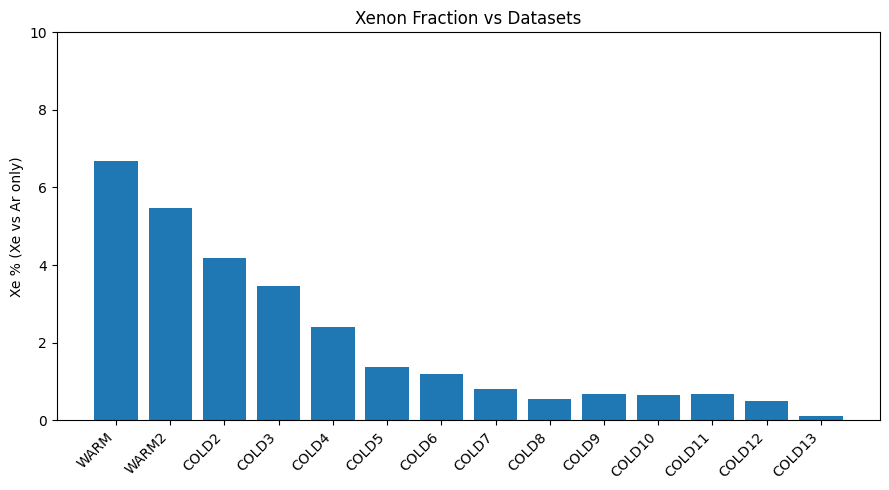

In [8]:
def xe_percent(df_bs, windows=WINDOWS):
    parts = compositions(df_bs, windows)[0]  # <-- take Parts only
    Xe = parts["Xe_Single"] + parts["Xe_Double"]
    Ar = parts["Ar_Single"] + parts["Ar_Double"]
    denom = Xe + Ar
    if denom <= 0:
        raise ValueError("Xe + Ar is zero or negative; check your windows or data.")
    return 100 * Xe / denom


def xe_percent_series(files, backgrounds, windows=WINDOWS, names=None):
    if names is None:
        names = [Path(f).stem for f in files]
    out = []
    for nm, fp in zip(names, files):
        df = read_rga(fp)
        df_bs = subtract_background(df, backgrounds)
        xp = xe_percent(df_bs, windows)
        out.append((nm, xp))
    return pd.DataFrame(out, columns=["Dataset", "Xe_%"])

def read_rga(fp):
        df = ReadFile(fp)  # your existing reader
        # match your earlier renames
        df = df.rename(columns={
            "              Mass (AMU)": "Mass",
            "         Intensity (Torr)": "Intensity",
            "Mass (AMU)": "Mass",
            "Intensity (Torr)": "Intensity",
            "Partial Pressure": "Intensity",
        })
        # keep only numeric Mass/Intensity, sorted
        df = df[["Mass", "Intensity"]].apply(pd.to_numeric, errors="coerce").dropna()
        df = df.sort_values("Mass").reset_index(drop=True)
        return df

files = [
    "WARM.txt",
    "WARM2.txt",
    "COLD2.txt",
    "COLD3.txt",
    "COLD4.txt",
    "COLD5.txt",
    "COLD6.txt",
    "COLD7.txt",
    "COLD8.txt",
    "COLD9.txt",
    "COLD10.txt",
    "COLD11.txt",
    "COLD12.txt",
    "COLD13.txt",
]
names = [Path(f).stem for f in files]  
xe_df = xe_percent_series(files, Background, WINDOWS, names)

plt.figure(figsize=(9,5))
plt.bar(xe_df["Dataset"], xe_df["Xe_%"])
plt.ylabel("Xe % (Xe vs Ar only)")
plt.title("Xenon Fraction vs Datasets")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 10)
plt.tight_layout()
plt.show()

In [9]:
# Example: values from compositions
XeWarm = PartsWarm["Xe_Single"] + PartsWarm["Xe_Double"]
XeCold = PartsCold["Xe_Single"] + PartsCold["Xe_Double"]
ArWarm = PartsWarm["Ar_Single"] + PartsWarm["Ar_Double"]
ArCold = PartsCold["Ar_Single"] + PartsCold["Ar_Double"]

# scale cold run so Ar matches warm
scale = ArWarm / ArCold if ArCold != 0 else 1.0
XeCold_scaled = XeCold * scale

# percent xenon captured
Xe_captured_percent = 100 * (XeWarm - XeCold_scaled) / XeWarm

print(f"Percent Xe captured: {Xe_captured_percent:.2f}%")


Percent Xe captured: 98.18%


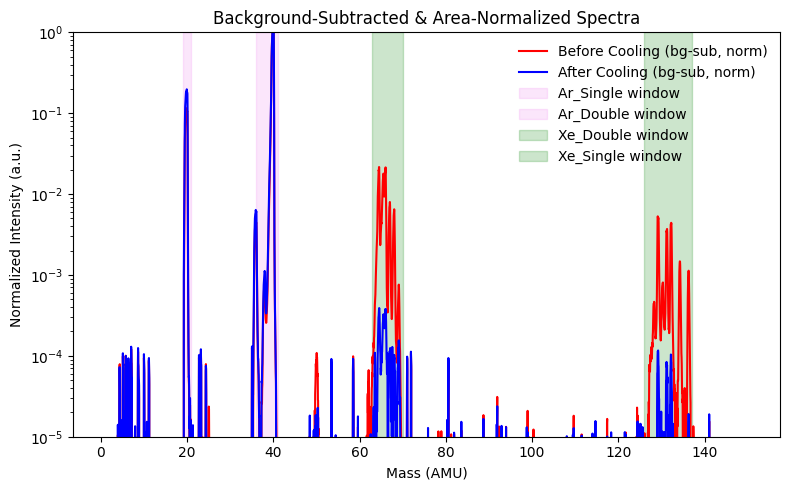

In [10]:
COLORS = {
    "Ar_Single": "violet",
    "Ar_Double": "violet",
    "Xe_Single": "green",
    "Xe_Double": "green",
}

plt.figure(figsize=(8,5))
plt.plot(DataWarm_BS["Mass"], DataWarm_BS["Intensity"], label="Before Cooling (bg-sub, norm)", color="red")
plt.plot(DataCold_BS["Mass"], DataCold_BS["Intensity"], label="After Cooling (bg-sub, norm)", color="blue")

# Highlight ROIs
for name, (lo, hi) in WINDOWS.items():
    plt.axvspan(lo, hi, alpha=0.2, color=COLORS.get(name, "gray"), label=f"{name} window")

plt.yscale("log")
plt.xlabel("Mass (AMU)")
plt.ylabel("Normalized Intensity (a.u.)")
#plt.xlim(35, 50)  
plt.ylim(1e-5, 1)
plt.title("Background-Subtracted & Area-Normalized Spectra")

# Avoid duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), frameon=False)

plt.tight_layout()
plt.show()


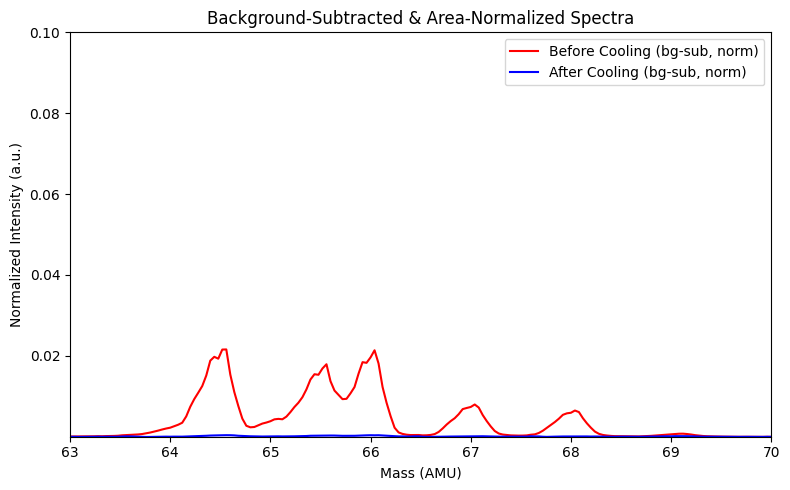

In [11]:
plt.figure(figsize=(8,5))
plt.plot(DataWarm_BS["Mass"], DataWarm_BS["Intensity"],label="Before Cooling (bg-sub, norm)", color="Red")
plt.plot(DataCold_BS["Mass"], DataCold_BS["Intensity"],label="After Cooling (bg-sub, norm)", color="Blue")
plt.xlabel("Mass (AMU)")
plt.xlim(63,70)
plt.ylabel("Normalized Intensity (a.u.)")
plt.ylim(1e-5,.1)
plt.title("Background-Subtracted & Area-Normalized Spectra")
plt.legend()
plt.tight_layout()
plt.show()

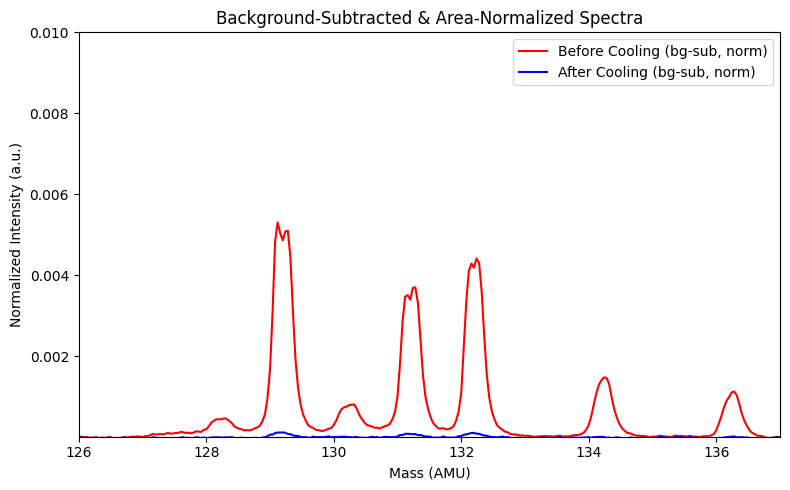

In [12]:
plt.figure(figsize=(8,5))
plt.plot(DataWarm_BS["Mass"], DataWarm_BS["Intensity"],label="Before Cooling (bg-sub, norm)", color="Red")
plt.plot(DataCold_BS["Mass"], DataCold_BS["Intensity"],label="After Cooling (bg-sub, norm)", color="Blue")
plt.xlabel("Mass (AMU)")
plt.xlim(126,137)
plt.ylabel("Normalized Intensity (a.u.)")
plt.ylim(1e-5,.01)
plt.title("Background-Subtracted & Area-Normalized Spectra")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# My overall Xenon percent was confusing so I wanted to validate my analysis by redoing Krishans of Alpha 0 using 
# The same data set up by technique. I find that I agree with his anlaysis (he got 2.08% I get 2.06%) I believe
# The 10% Xe is due to multiple cycles gets the Xe near the bottle (and therefore the RGA) but I never circulate so it slowly gets back to 
# CRAB but not well thusly making subsquent captures easier

import numpy as np, pandas as pd

background_files = ["Background5_0.5AMUperSec.txt"]
leak_files       = ["LeakTest2_0.5AMUperSec.txt"]
leak_names       = ["LeakTest2"]  # match length to leak_files

def find_data_start(path):
    with open(path,"r",errors="ignore") as f:
        for i,line in enumerate(f):
            if line.strip()=="Analog Scan Data": return i+3
    return 0

def read_rga(path):
    df = pd.read_csv(path, skiprows=find_data_start(path), delimiter=",")
    df.columns = df.columns.astype(str).str.replace(r"\s+"," ",regex=True).str.strip()
    df = df.rename(columns={"Mass (AMU)":"Mass","Intensity (Torr)":"Intensity","Partial Pressure":"Intensity"})
    df = df[["Mass","Intensity"]].apply(pd.to_numeric, errors="coerce").dropna().sort_values("Mass").reset_index(drop=True)
    return df

def avg_background_intensity_at(masses, bkgs):
    vals = [np.interp(masses, b["Mass"].to_numpy(), b["Intensity"].to_numpy()) for b in bkgs]
    return np.mean(np.vstack(vals), axis=0)

def subtract_background(df, bkgs):
    m = df["Mass"].to_numpy()
    y = df["Intensity"].to_numpy()
    yb = avg_background_intensity_at(m, bkgs)
    out = df.copy()
    out["Intensity"] = y - yb
    return out

def integrate_window(df, lo, hi):
    m = df["Mass"].to_numpy()
    y = np.clip(df["Intensity"].to_numpy(), 0, None)
    mask = (m>=lo)&(m<=hi)
    return float(np.trapz(y[mask], m[mask])) if mask.any() else 0.0

def compositions(df_bs, WINDOWS):
    Parts = {name: integrate_window(df_bs, *win) for name,win in WINDOWS.items()}

    total_pos = integrate_window(df_bs, float(df_bs["Mass"].min()), float(df_bs["Mass"].max()))
    Parts["Other"] = max(total_pos - sum(Parts.values()), 0.0)

    Xe = Parts["Xe_Single"] + Parts["Xe_Double"]
    Ar = Parts["Ar_Single"] + Parts["Ar_Double"]

    Tot = Xe + Ar + Parts["Other"]

    Frac = {
        "Xe_Single": 100*Parts["Xe_Single"]/Tot if Tot>0 else 0.0,
        "Xe_Double": 100*Parts["Xe_Double"]/Tot if Tot>0 else 0.0,
        "Ar_Single": 100*Parts["Ar_Single"]/Tot if Tot>0 else 0.0,
        "Ar_Double": 100*Parts["Ar_Double"]/Tot if Tot>0 else 0.0,
        "Other":     100*Parts["Other"]/Tot     if Tot>0 else 0.0,}

    Frac_noOther = {
        "Xe": 100*Xe/(Xe+Ar) if (Xe+Ar)>0 else 0.0,
        "Ar": 100*Ar/(Xe+Ar) if (Xe+Ar)>0 else 0.0}

    Parts["Xe"] = Xe
    Parts["Ar"] = Ar
    Parts["Total"] = Tot

    return Parts, Frac, Frac_noOther

Backgrounds = [read_rga(p) for p in background_files]
Leaks       = [(name, read_rga(p)) for name,p in zip(leak_names, leak_files)]

WINDOWS = {
    "Ar_Single":  (36.0, 41.0),
    "Ar_Double":  (19.0, 21.0),
    "Xe_Double":  (62.0, 70.0),     
    "Xe_Single":  (124.0, 136.5),}

for name, df in Leaks:
    df_bs = subtract_background(df, Backgrounds)
    Parts, Frac, FracPair = compositions(df_bs, WINDOWS)

    Xe   = Parts["Xe"]
    Ar   = Parts["Ar"]
    Tot  = Parts["Total"]

    Frac_Xe = 100*Xe/Tot if Tot>0 else 0.0
    Frac_Ar = 100*Ar/Tot if Tot>0 else 0.0
    Frac_Ot = 100*Parts["Other"]/Tot if Tot>0 else 0.0

    print(f"\n=== {name} ===")
    print(f"With Other:   Xe={Frac_Xe:.3f}%  Ar={Frac_Ar:.3f}%  Other={Frac_Ot:.3f}%  (sum={(Frac_Xe+Frac_Ar+Frac_Ot):.3f}%)")
    print(f"Xe vs Ar only: Xe={FracPair['Xe']:.3f}%  Ar={FracPair['Ar']:.3f}%")



=== LeakTest2 ===
With Other:   Xe=1.463%  Ar=79.907%  Other=18.630%  (sum=100.000%)
Xe vs Ar only: Xe=1.798%  Ar=98.202%
